In [425]:
# importamos las librerías que necesitamos
# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np

# Imputación de nulos usando métodos avanzados estadísticos
# -----------------------------------------------------------------------
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

# Librerías de visualización
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
# Configuración
# -----------------------------------------------------------------------
pd.set_option('display.max_columns', None) # para poder visualizar todas las columnas de los DataFrames

In [426]:
df = pd.read_csv("data/finanzas_hotel_bookings.csv", index_col=0, low_memory=False)

In [427]:
# Eliminamos ultimas filas que tienen en su mayoría valores nulos y no sirven para el análisis
df = df.iloc[:119390]

In [428]:
df.drop("0", axis = 1, inplace = True) # Elimina la COLUMNA y sobreescribe los cambios

In [429]:
def convertir_a_boleano(df, columnas):
    """
    Convierte las columnas especificadas de un DataFrame a tipo booleano.

    Parámetros:
    df (pandas.DataFrame): El DataFrame en el que se encuentran las columnas.
    columnas (list): Lista de nombres de columnas a convertir.

    Retorna:
    pandas.DataFrame: El DataFrame con las columnas convertidas a booleano.
    """
    print(f'El tipo de dato antes del cambio \n {df["is_repeated_guest"].dtype} \n {df["is_canceled"].dtype}')
    
    for columna in columnas:
        df[columna] = df[columna].astype(bool)
    print(f'El tipo de dato después del cambio \n {df["is_repeated_guest"].dtype} \n {df["is_canceled"].dtype}')
    return df

columnas = ["is_repeated_guest", "is_canceled"]
df = convertir_a_boleano(df, columnas)


# Convierte los valores de la columna a positivos
df['adr'] = df['adr'].abs()

El tipo de dato antes del cambio 
 float64 
 object
El tipo de dato después del cambio 
 bool 
 bool


In [430]:
# →  Estandarizar para que en todos los casos sean números y cambiar el datatype de la columna a número entero.

def cambiar_formato_mes(df):
    # Diccionario de mapeo de meses y valores numéricos
    dic_map = {
        'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 
        'June': 6, 'July': 7, 'August': 8, 'September': 9, 'October': 10, 
        'November': 11, 'December': 12, 
        1: 1, 2: 2, 3: 3, 4:4, 5:5, 6:6, 7:7, 8:8, 9:9, 10:10, 11:11, 12:12, 'nan': np.nan}
    
    # Asegurarse de que los valores en la columna sean de tipo string para mapear correctamente
    df['arrival_date_month'] = df['arrival_date_month'].astype(str).map(dic_map).astype('Int64')

    return df

df = cambiar_formato_mes(df)

In [431]:
def rellenar_año_llegada(df):  

    print(f'nulos antes de hacer la operación {df["arrival_date_year"].isna().sum()}')

    # Asegúrate de que las columnas de fecha estén en formato datetime
    df['reservation_status_date'] = pd.to_datetime(df['reservation_status_date'], errors='coerce')

    # Crear una columna para el total de la estancia
    df['total_stays'] = df['stays_in_weekend_nights'] + df['stays_in_week_nights']

    # Inicializar la columna de fecha de llegada estimada con valores NaT (Not a Time)
    df['estimated_arrival_date'] = pd.NaT

    # Crear filtro para cuando el estado de la reserva es "Checkout"
    filtro_checkout = df['reservation_status'] == 'Checkout'

    # Calcular fecha de llegada estimada solo para "Checkout"
    df.loc[filtro_checkout, 'estimated_arrival_date'] = df.loc[filtro_checkout, 'reservation_status_date'] - pd.to_timedelta(df.loc[filtro_checkout, 'total_stays'], unit='D')

    # Extraer el año de la fecha de llegada estimada
    df['estimated_arrival_year'] = df['estimated_arrival_date'].dt.year

    # Para los que no son "Checkout", usar el año de la fecha de estado de reserva
    df.loc[~filtro_checkout, 'estimated_arrival_year'] = df.loc[~filtro_checkout, 'reservation_status_date'].dt.year

    # Rellenar los valores nulos en arrival_date_year con el año estimado
    df['arrival_date_year'] = df['arrival_date_year'].fillna(df['estimated_arrival_year'])

    print(f'nulos después de hacer la operación {df["arrival_date_year"].isna().sum()}')

    return df

df = rellenar_año_llegada(df)

nulos antes de hacer la operación 54561
nulos después de hacer la operación 5936


In [432]:
# 1.Reemplazar los nulos con "0000-00-00"

def imputar_fechas_nulas(df, columns):
        """ Dada una lista de columnas y un dataframe, esta función completa los nulos en las columnas con "0000-00-00".
        """
        # Iterar sobre la lista de columnas y reemplazar nulos por "0000-00-00"
        for column in columns:
            # verifica si la columna existe en el dataframe
            if column in df.columns:
                # Reemplaza los nulos con "0000-00-00"
                df[column] = df[column].fillna("0000-00-00")
            # si la columna no existe imprime un mensaje
            else:
                print(f"❌ La columna '{column}' no existe en el dataframe dado")
        return df

columns = ['reservation_status_date']
df = imputar_fechas_nulas(df, columns)

In [415]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,total_stays,estimated_arrival_date,estimated_arrival_year
0,Resort Hotel,False,342.0,2015.0,7,27.0,1.0,0.0,0.0,2.0,NaN,0.0,BB,PRT,NaN,Direct,False,NaN,0.0,C,C,3.0,NaN,NaN,0.0,Transient,0.0,0.0,0.0,Check-Out,2015-07-01 00:00:00,0.0,NaT,2015.0
1,Resort Hotel,False,737.0,2015.0,7,27.0,1.0,0.0,0.0,2.0,NaN,0.0,BB,NaN,NaN,Direct,False,0.0,0.0,NaN,C,4.0,NaN,NaN,0.0,Transient,0.0,0.0,0.0,Check-Out,2015-07-01 00:00:00,0.0,NaT,2015.0
2,Resort Hotel,False,7.0,2015.0,7,27.0,1.0,0.0,1.0,1.0,0.0,0.0,BB,GBR,NaN,Direct,False,0.0,0.0,A,C,0.0,NaN,NaN,0.0,Transient,75.0,0.0,0.0,Check-Out,2015-07-02 00:00:00,1.0,NaT,2015.0
3,Resort Hotel,False,13.0,2015.0,7,27.0,1.0,0.0,1.0,1.0,NaN,0.0,BB,GBR,Corporate,Corporate,False,0.0,0.0,A,A,0.0,304.0,NaN,0.0,Transient,75.0,0.0,0.0,Check-Out,2015-07-02 00:00:00,1.0,NaT,2015.0
4,Resort Hotel,False,14.0,2015.0,7,NaN,1.0,0.0,2.0,2.0,NaN,0.0,BB,NaN,Online TA,TA/TO,False,0.0,0.0,A,A,0.0,240.0,NaN,0.0,Transient,98.0,0.0,1.0,Check-Out,2015-07-03 00:00:00,2.0,NaT,2015.0


In [416]:
df["adults"].value_counts()

2.0     82156
1.0     21094
3.0      5716
59.0     1035
54.0     1025
51.0     1011
58.0     1005
50.0      999
57.0      998
53.0      984
56.0      975
55.0      959
52.0      936
0.0       369
4.0        53
19.0       13
14.0       10
12.0        7
10.0        7
11.0        6
15.0        5
26.0        5
18.0        5
16.0        5
13.0        4
27.0        2
5.0         2
20.0        2
6.0         1
17.0        1
Name: adults, dtype: int64

Vemos que hay un número muy elevado de adultos en una misma habitación. Vamos a ver si esa habitación corresponde siempre al mismo tipo y sacar conclusiones de que pueda ser un salón de actos, comedor, sala de juntas, etc. 

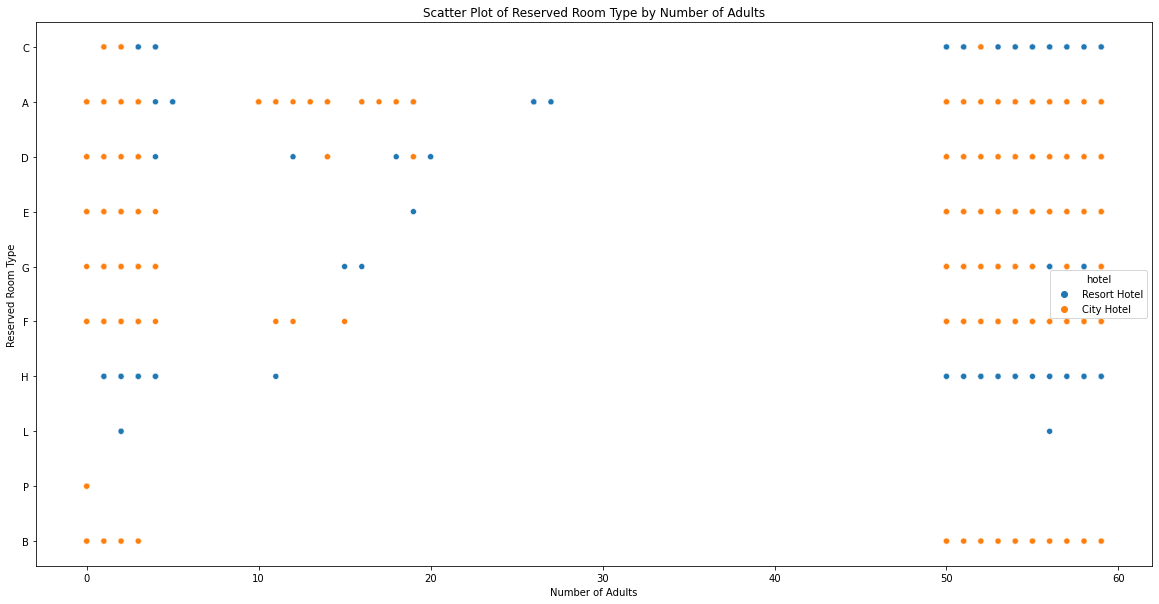

In [417]:
# Graficar la relación entre el número de adultos y el tipo de habitación reservada
plt.figure(figsize=(20, 10))
sns.scatterplot(x='adults', 
                y='reserved_room_type',
                data=df, hue='hotel')
plt.xlabel('Number of Adults')
plt.ylabel('Reserved Room Type')
plt.title('Scatter Plot of Reserved Room Type by Number of Adults')
plt.show()

Text(0.5, 1.0, 'Número de Adultos por Tipo de Habitación')

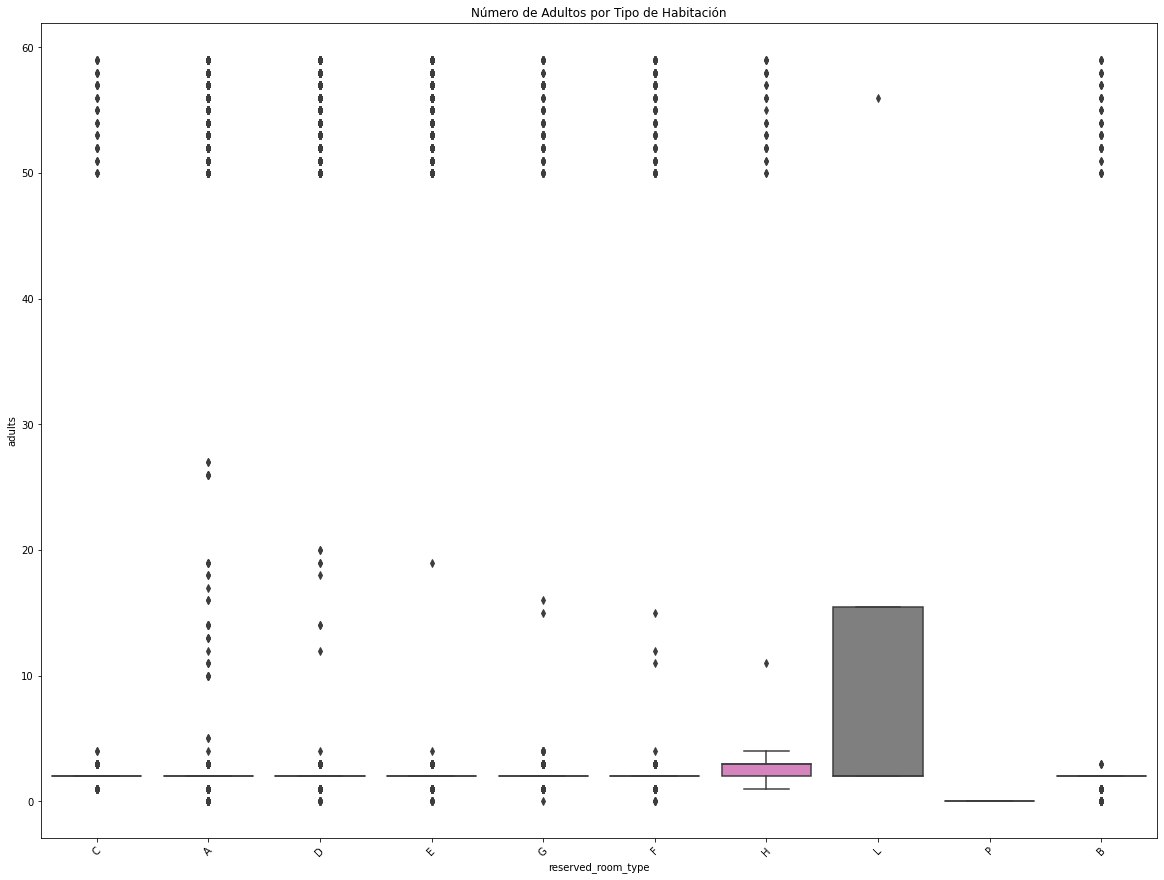

In [418]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 15))
# Relación entre el tipo de habitación y el número de adultos
sns.boxplot(x='reserved_room_type', y='adults', data=df)
plt.xticks(rotation=45)
plt.title('Número de Adultos por Tipo de Habitación')

In [421]:
df["children"].value_counts()/df.shape[0]

0.0     0.537909
1.0     0.023427
2.0     0.017908
3.0     0.000377
18.0    0.000101
14.0    0.000101
10.0    0.000075
11.0    0.000067
15.0    0.000059
17.0    0.000042
13.0    0.000042
16.0    0.000042
19.0    0.000025
12.0    0.000025
Name: children, dtype: float64

In [424]:
def imputar_nulos_iterative (df, columns):
    """
    Dada una lista de columnas y un DataFrame, esta función completa los nulos de las columnas con el método IterativeImputer.
    Además, redondea los valores imputados a enteros y asegura que no haya valores negativos.
    
    Parámetros:
    df (pd.DataFrame): El DataFrame a procesar.
    columns (list): Lista de nombres de columnas a imputar.
    
    Retorna:
    pd.DataFrame: El DataFrame con los valores nulos imputados.
    """

    # Número de Nan y distribución antes de aplicar el método
    for column in columns:
        print(f"Porcentaje de NaN en '{column}': {df[column].isna().sum() / df.shape[0]:.2f}%")
        print(df[column].value_counts() / df.shape[0] * 100)

    # instanciamos las clases
    imputer_iterative = IterativeImputer(max_iter = 20, random_state = 42)  
    # ajustamos y tranformamos los datos
    imputer_iterative_imputado = imputer_iterative.fit_transform(df[columns])

    # Redondeamos los valores imputados a enteros
    imputer_iterative_imputado = np.round(imputer_iterative_imputado).astype(int)
    
    # Nos aseguramos de que no haya valores negativos
    imputer_iterative_imputado[imputer_iterative_imputado < 0] = 0

    # Asignamos los valores imputados de vuelta al DataFrame
    df[columns] = imputer_iterative_imputado

    # Número de Nan y distribución después de aplicar el método
    for column in columns:
        print(f"Porcentaje de NaN en '{column}': {df[column].isna().sum() / df.shape[0]:.2f}%")
        print(df[column].value_counts() / df.shape[0] * 100)

    return df

columnas = ["children", "previous_cancellations"]
df = imputar_nulos_iterative(df, columnas )

Porcentaje de NaN en 'children': 0.00%
0     95.771003
1      2.342742
2      1.790770
3      0.037692
18     0.010051
14     0.010051
10     0.007538
11     0.006701
15     0.005863
17     0.004188
13     0.004188
16     0.004188
19     0.002513
12     0.002513
Name: children, dtype: float64
Porcentaje de NaN en 'previous_cancellations': 0.36%
0.0     60.273055
1.0      3.248178
2.0      0.063657
3.0      0.034341
11.0     0.028478
24.0     0.027641
19.0     0.017589
4.0      0.016752
26.0     0.015077
25.0     0.015077
14.0     0.014239
13.0     0.014239
5.0      0.011726
6.0      0.010051
17.0     0.005863
12.0     0.005863
18.0     0.005026
16.0     0.004188
10.0     0.004188
15.0     0.004188
21.0     0.000838
Name: previous_cancellations, dtype: float64
Porcentaje de NaN en 'children': 0.00%
0     95.771003
1      2.342742
2      1.790770
3      0.037692
18     0.010051
14     0.010051
10     0.007538
11     0.006701
15     0.005863
17     0.004188
13     0.004188
16     0.004188

In [ ]:
df["children"].isna().sum() / df.shape[0]

0.0

Vemmos que hay un número muy elevado de niños en una misma habitación, que pasa de 3 a más de 10

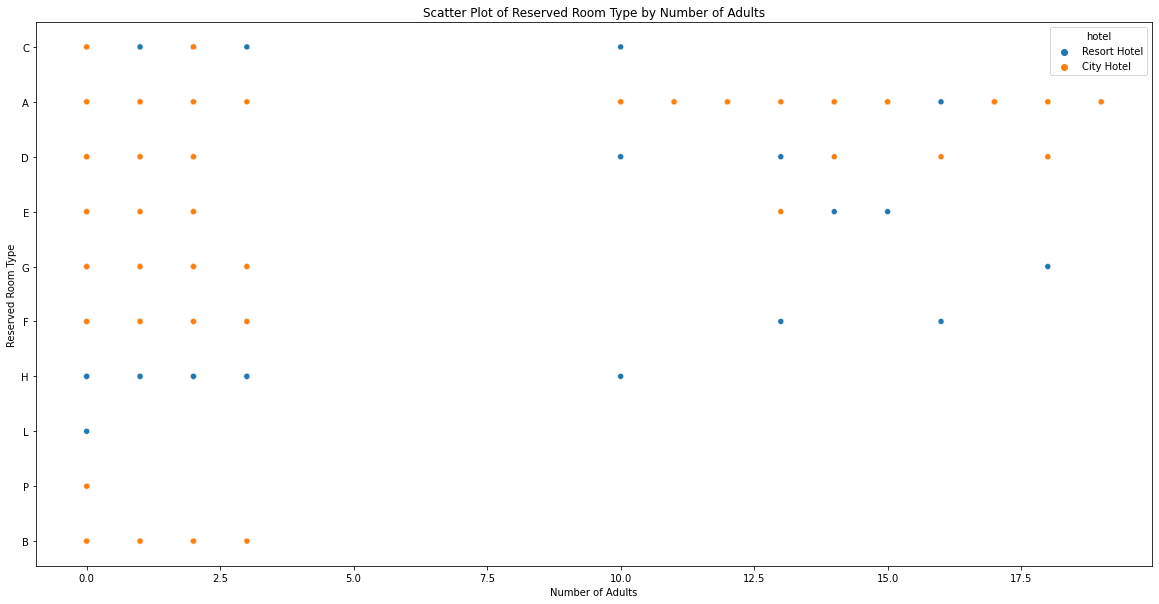

In [499]:
# Graficar la relación entre el número de adultos y el tipo de habitación reservada
plt.figure(figsize=(20, 10))
sns.scatterplot(x='children', 
                y='reserved_room_type',
                data=df, hue='hotel')
plt.xlabel('Number of Adults')
plt.ylabel('Reserved Room Type')
plt.title('Scatter Plot of Reserved Room Type by Number of Adults')
plt.show()

Text(0.5, 1.0, 'Número de Niños por Tipo de Habitación')

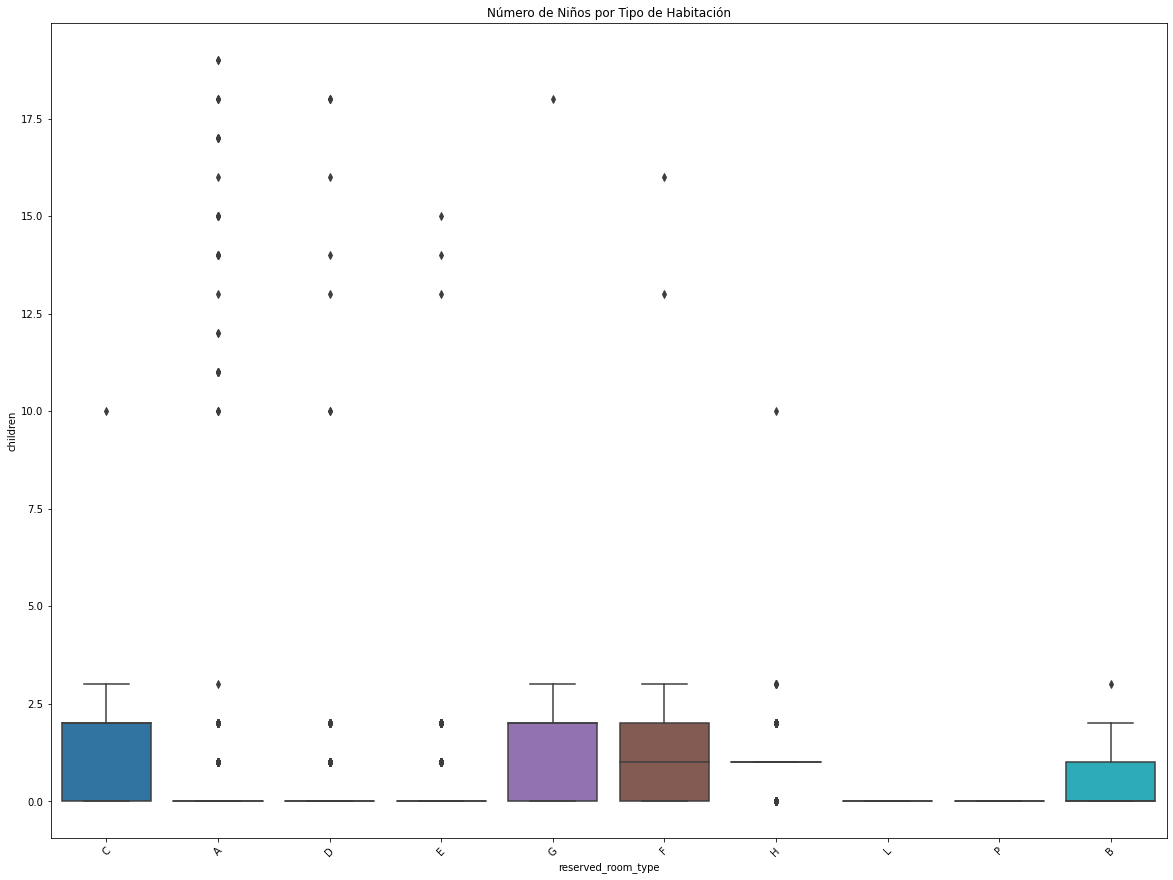

In [ ]:
plt.figure(figsize=(20, 15))
# Relación entre el tipo de habitación y el número de niños
sns.boxplot(x='reserved_room_type', y='children', data=df)
plt.xticks(rotation=45)
plt.title('Número de Niños por Tipo de Habitación')

In [ ]:
df["babies"].value_counts()

0.0     118414
1.0        900
2.0         15
16.0        11
12.0        11
10.0        11
19.0         7
18.0         5
15.0         4
11.0         4
17.0         3
13.0         3
9.0          1
14.0         1
Name: babies, dtype: int64

Vemos que hay un número muy elevado de bebes en la misma habitación. Pasando de 2 a más de 9

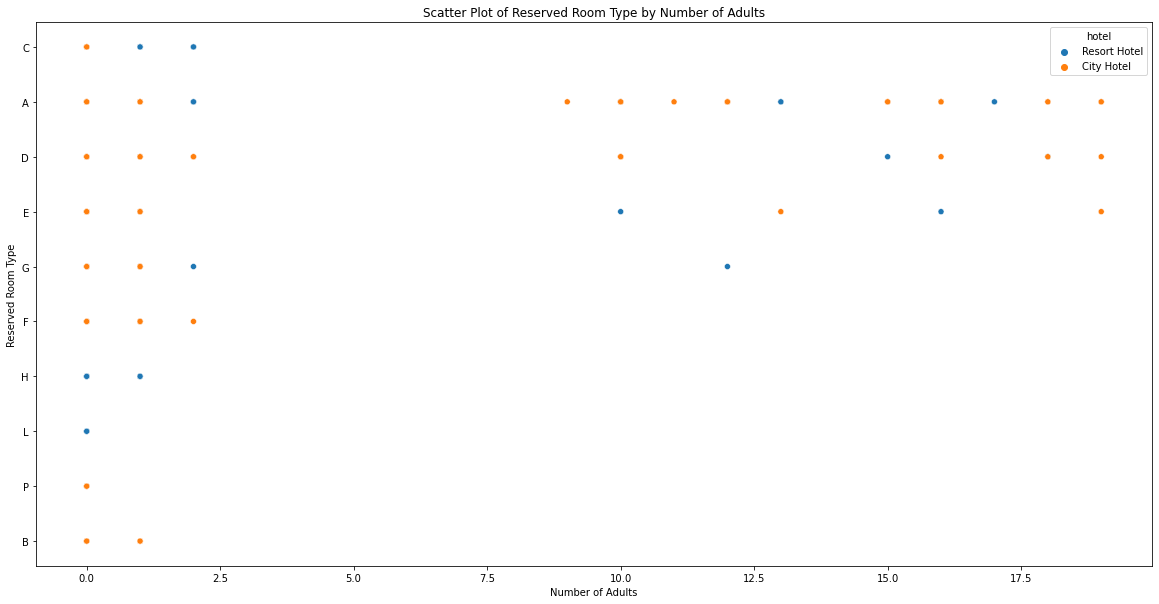

In [ ]:
# Graficar la relación entre el número de adultos y el tipo de habitación reservada
plt.figure(figsize=(20, 10))
sns.scatterplot(x='babies', 
                y='reserved_room_type',
                data=df, hue='hotel')
plt.xlabel('Number of Adults')
plt.ylabel('Reserved Room Type')
plt.title('Scatter Plot of Reserved Room Type by Number of Adults')
plt.show()

Text(0.5, 1.0, 'Número de Bebés por Tipo de Habitación')

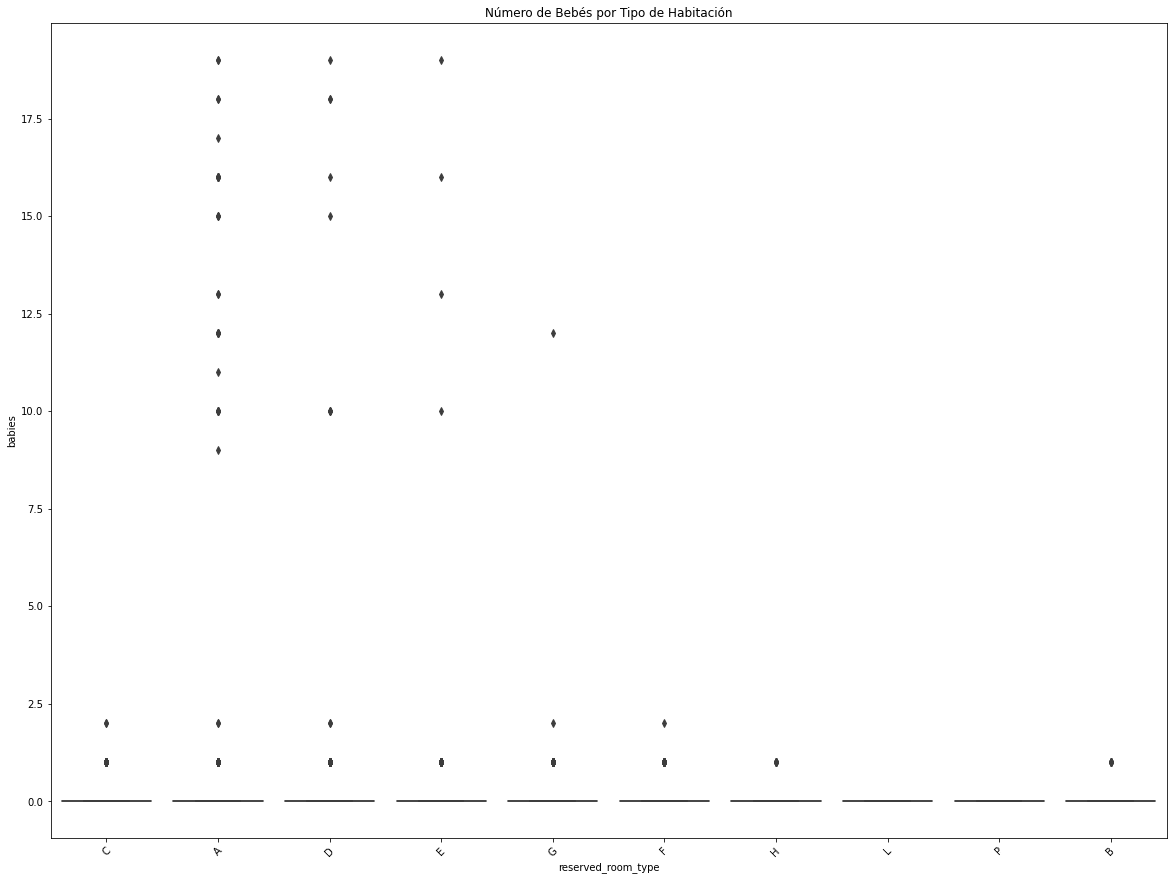

In [ ]:
plt.figure(figsize=(20, 15))
# Relación entre el tipo de habitación y el número de bebés
sns.boxplot(x='reserved_room_type', y='babies', data=df)
plt.xticks(rotation=45)
plt.title('Número de Bebés por Tipo de Habitación')

In [ ]:
df_mas_de30_adultos = df[df["adults"]>30]

In [503]:
df_mas_de30_adultos.tail()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,total_stays,estimated_arrival_date,estimated_arrival_year
119362,City Hotel,False,198.0,2017.0,8,35.0,29.0,1.0,5.0,55.0,0.0,0.0,BB,ITA,Online TA,TA/TO,False,NaN,0.0,A,A,2.0,9.0,NaN,0.0,Transient,119.17,0.0,2.0,Check-Out,2017-04-09 00:00:00,6.0,NaT,2017.0
119367,City Hotel,False,212.0,2017.0,8,NaN,28.0,2.0,5.0,54.0,NaN,0.0,BB,NaN,NaN,TA/TO,False,NaN,0.0,A,A,0.0,7.0,NaN,0.0,Transient,85.59,0.0,0.0,Check-Out,2017-04-09 00:00:00,7.0,NaT,2017.0
119372,City Hotel,False,175.0,2017.0,8,35.0,31.0,1.0,3.0,51.0,0.0,0.0,BB,NaN,Offline TA/TO,TA/TO,False,NaN,0.0,A,A,0.0,42.0,NaN,0.0,Transient,82.35,0.0,1.0,Check-Out,2017-04-09 00:00:00,4.0,NaT,2017.0
119379,City Hotel,False,109.0,2017.0,8,35.0,31.0,1.0,3.0,50.0,NaN,0.0,BB,GBR,Online TA,TA/TO,False,0.0,0.0,D,D,0.0,9.0,NaN,0.0,NaN,155.00,0.0,1.0,Check-Out,2017-04-09 00:00:00,4.0,NaT,2017.0
119388,City Hotel,False,109.0,2017.0,8,35.0,31.0,2.0,5.0,55.0,0.0,0.0,BB,NaN,Online TA,TA/TO,False,0.0,0.0,A,A,0.0,89.0,NaN,0.0,Transient,104.40,0.0,0.0,Check-Out,2017-07-09 00:00:00,7.0,NaT,2017.0


In [534]:
df_mas_de30_adultos["customer_type"].value_counts()

Transient          5815
Transient-Party    1670
Contract            257
Group                41
Name: customer_type, dtype: int64

No se ve ningún patrón que explique un número elevado de adultos en la habitación

In [475]:
df['market_segment'] = df['market_segment'].fillna('NaN')
df['distribution_channel'] = df['distribution_channel'].fillna('NaN')

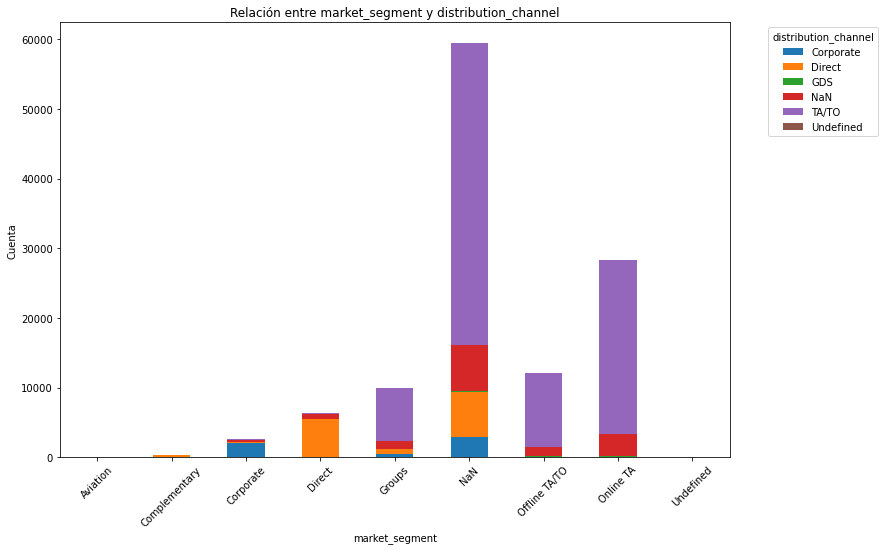

In [498]:
import pandas as pd
import matplotlib.pyplot as plt

# Crea una tabla de contingencia
contingency_table = pd.crosstab(df['market_segment'], df['distribution_channel'])

# Grafica la tabla de contingencia como barras apiladas
contingency_table.plot(kind='bar', stacked=True, figsize=(12, 8))

plt.title('Relación entre market_segment y distribution_channel')
plt.xlabel('market_segment')
plt.ylabel('Cuenta')
plt.xticks(rotation=45)
plt.legend(title='distribution_channel', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


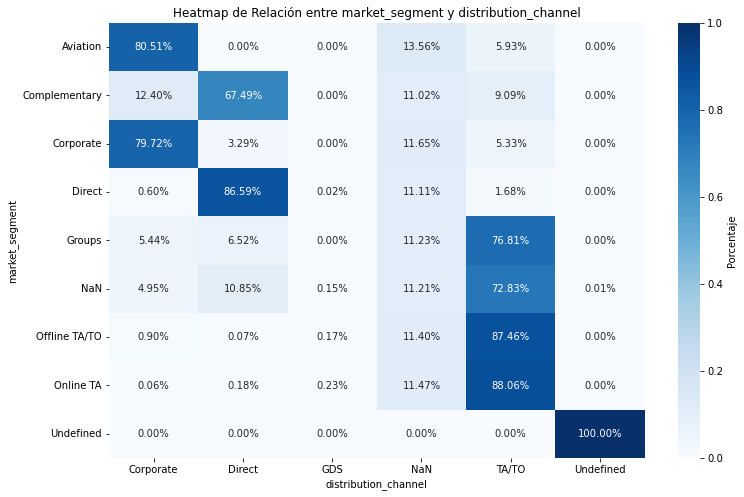

In [485]:
# Crear una tabla de contingencia para el heatmap
contingency_table = pd.crosstab(df['market_segment'], df['distribution_channel'], normalize='index')

plt.figure(figsize=(12, 8))
sns.heatmap(contingency_table, annot=True, fmt=".2%", cmap='Blues', cbar_kws={'label': 'Porcentaje'})

plt.title('Heatmap de Relación entre market_segment y distribution_channel')
plt.xlabel('distribution_channel')
plt.ylabel('market_segment')
plt.show()

Conclusiones rápidas:

- El 80% del mercado "aviation" es por el canal "Corporate" y el 14% son Nan. ¿Ponemos esos Nan a Corporate? 

- Ver "Complementary"

- El 80% del mercado "corporate" es por el canal "corporate" y el 11% son Nan. ¿Ponemos esos Nan a Corporate? 

- El 87% de "direct" es por el canal "Direct" y el 11% son Nan. ¿Ponemos esos Nan a Direct? 

- El 77% de "groups" es por el canal "TA/TO" y el 11% son Nan. ¿Ponemos esos Nan a TA/TO? 

- El 72,83 % de los Nan en la columna "market_segment" corresponden a TA/TO en la columna "distribution_channel". ¿Ponemos esos Nan a TA/TO? 

- El 87% de "Offline TA/TO" es por el canal "TA/TO" y el 11% son Nan. ¿Ponemos esos Nan a TA/TO? 

- El 88% de "online TA" es por el canal "TA/TO" y el 11% son Nan. ¿Ponemos esos Nan a TA/TO? 

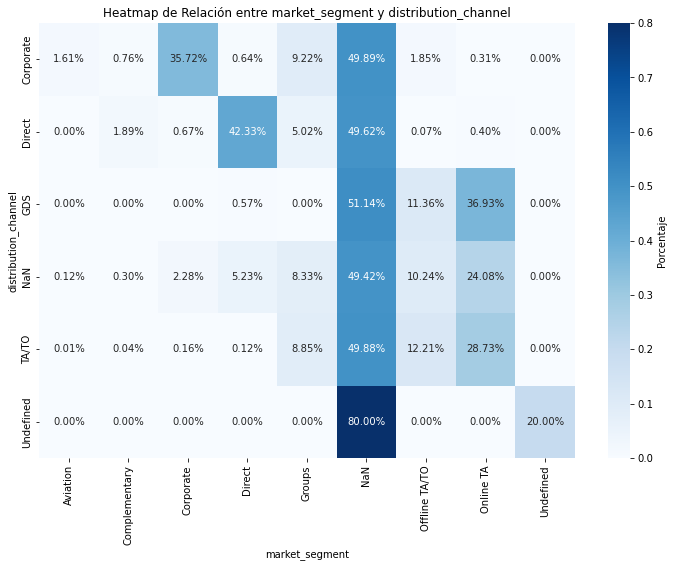

In [502]:
# Crear una tabla de contingencia para el heatmap
contingency_table = pd.crosstab(df['distribution_channel'], df['market_segment'], normalize='index')

plt.figure(figsize=(12, 8))
sns.heatmap(contingency_table, annot=True, fmt=".2%", cmap='Blues', cbar_kws={'label': 'Porcentaje'})

plt.title('Heatmap de Relación entre market_segment y distribution_channel')
plt.xlabel('market_segment')
plt.ylabel('distribution_channel')
plt.show()